In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from pathlib import Path
import pickle
import itertools
from IPython.display import Image

In [4]:
from mmfitting import crossval_summarize_mm

In [5]:
%matplotlib inline

# Prelude to assessing fits

Before assessing model fits, it is assumed that the following has already occured:

* simulation scenarios file has been created and uses same column names as `exp10_obflow06_metainputs.csv`
* `obsimpy.create_configs.py` run using scenarios file to create yaml config files for simulation runs. In addition to the
YAML config files, a bash script is created with the python commands for running the simulation model for each scenario.
* obflow_06 simulation runs have been completed and occ and stop log files and occ stat files are created
* `obsimpy.obflow_06_output.py` has been run to process the logs and create the main summary files:
    - `scenario_rep_simout_{suffix}.csv` - sim outputs by scenario by rep (NO inputs)
    - `scenario_rep_siminout_{suffix}.csv` - sim inputs and outputs by scenario by rep
    - `scenario_simout_{suffix}.csv` - sim outputs by scenario (NO inputs)
    
Then we need to run `dataprep.py` from the `mm_interpret` project. It has a simple CLI or you can override and run directly. It will:

* Create `scenario_siminout_qng_{suffix}.csv` - sim inputs, outputs and queueing approximations by scenario
* Create all the X and y csv files for model fitting.

Now we are ready for model fitting using the `mm_interpret` project. The following scripts do **NOT** have CLI's implemented. Instead we have to set some variable values manually:

    experiment = "exp11"
    data_path = Path("data")
    output_path = Path("output")
    figures_path = Path("output", "figures")
    raw_data_path = Path("data", "raw")
    pickle_filename = f"ldr_results_{experiment}.pkl"

* `run_mm_fits_ldr.py` --> `ldr_results_exp11.pkl`
* `run_mm_fits_pp.py` --> `pp_results_exp11.pkl`
* `run_mm_fits_obs.py` --> `obs_results_exp11.pkl`


The pickle files contain the fitting model objects. Now we can use those model objects to create actual vs predicted plot for each model. Use `process_fitted_models.py`.

> **IMPORTANT NOTE** Exp11 was rerun without the infinite capacity scenarios as they represent values of rho which are far outside the range of values used in the finite capacity scenarios (~.5 to ~.8). After debugging the exp11 results to make sure everything being computed correctly, perhaps we should run an experiment with a wider and more uniform range of rho values. Specify rho instead of using overflow target approximations.

In [ ]:
output_path = "output"

obs_pkl_filename =  "obs_results_exp11.pkl"
ldr_pkl_filename =  "ldr_results_exp11.pkl"
pp_pkl_filename =  "pp_results_exp11.pkl"

obs_pkl_path = Path(output_path, obs_pkl_filename)
ldr_pkl_path = Path(output_path, ldr_pkl_filename)
pp_pkl_path = Path(output_path, pp_pkl_filename)

## PP results
Starting here since no downstream units to block patients are not LOS adjustments due to blocking.

In [ ]:
with open(pp_pkl_path, 'rb') as pickle_file:
    pp_results = pickle.load(pickle_file)

In [ ]:
pp_results.keys()

### PP mean occupancy

#### lm and lassocv

Let's start here as they are simplest.

In [ ]:
figures_path = Path("output", "figures", "exp11", "exp11_pp_pp_occ_mean_noq_lm_cv_scatter.png")
Image(filename=figures_path) 

Linear model with noq does pretty well. What if we add the basicq fields? The queueing fields definitely help.

In [ ]:
figures_path = Path("output", "figures", "exp11", "exp11_pp_pp_occ_mean_basicq_lm_cv_scatter.png")
Image(filename=figures_path) 

What do the coefficients look like?

Look pretty stable though some things don't make physics sense such as negative coeffs on `mean_los_pp` and `c_sect_prob`. Let's see if the lasso models can help with this issue.

In [ ]:
figures_path = Path("output", "figures", "exp11", "exp11_pp_pp_occ_mean_basicq_lm_cv_coeff.png")
Image(filename=figures_path) 

In [ ]:
figures_path = Path("output", "figures", "exp11", "exp11_pp_pp_occ_mean_basicq_lassocv_cv_scatter.png")
Image(filename=figures_path) 

Fit seems intermediate between noq and basicq.

In [ ]:
figures_path = Path("output", "figures", "exp11", "exp11_pp_pp_occ_mean_basicq_lassocv_cv_coeff.png")
Image(filename=figures_path) 

Driving the `sqrt_load_pp` term to 0 makes sense since mean occ should not depend on this. This has the desirable effect of all of the other coefficients having signs that make sense.

#### poly

Widely used, so let's see how it did.

In [ ]:
figures_path = Path("output", "figures", "exp11", "exp11_pp_pp_occ_mean_noq_poly_cv_scatter.png")
Image(filename=figures_path) 

The poly model fits very well even with no qng terms.

In [ ]:
figures_path = Path("output", "figures", "exp11", "exp11_pp_pp_occ_mean_basicq_lm_cv_scatter.png")
Image(filename=figures_path) 

What about the coeffs?

In [ ]:
figures_path = Path("output", "figures", "exp11", "exp11_pp_pp_occ_mean_basicq_poly_cv_coeff.png")
Image(filename=figures_path) 

Many variables. Some troubling sign swapping and overall coeff instability. Let's check for the noq version - at least there will be less variables.

In [ ]:
figures_path = Path("output", "figures", "exp11", "exp11_pp_pp_occ_mean_noq_poly_cv_coeff.png")
Image(filename=figures_path) 

Less sign swapping and more stable. Seems like many negative coefficients to offset the positive ones. Hard to explain.

#### The ML models - rf, nn, svr

In [ ]:
figures_path = Path("output", "figures", "exp11", "exp11_pp_pp_occ_mean_noq_rf_cv_scatter.png")
Image(filename=figures_path) 

Not as good as the linear models, especially at upper end of occupancy levels.

Do qnq terms help? Yes, they appear to help a bit.

In [ ]:
figures_path = Path("output", "figures", "exp11", "exp11_pp_pp_occ_mean_basicq_rf_cv_scatter.png")
Image(filename=figures_path) 

Now for the neural nets. Overall, they perform poorly and if the qng terms help, it's not much.

In [ ]:
figures_path = Path("output", "figures", "exp11", "exp11_pp_pp_occ_mean_noq_nn_cv_scatter.png")
Image(filename=figures_path) 

In [ ]:
figures_path = Path("output", "figures", "exp11", "exp11_pp_pp_occ_mean_basicq_nn_cv_scatter.png")
Image(filename=figures_path) 

Finally, let's look at the svrs. Overall, they perform poorly and if the qng terms help, it's not much.

In [ ]:
figures_path = Path("output", "figures", "exp11", "exp11_pp_pp_occ_mean_noq_svr_cv_scatter.png")
Image(filename=figures_path) 

In [ ]:
figures_path = Path("output", "figures", "exp11", "exp11_pp_pp_occ_mean_basicq_svr_cv_scatter.png")
Image(filename=figures_path) 

#### load
This uses the offered load as the estimate for mean occupancy. There is **no** model "fitting". It should perform well as it's really just Little's Law.

In [ ]:
figures_path = Path("output", "figures", "exp11", "exp11_pp_pp_occ_mean_basicq_load_cv_scatter.png")
Image(filename=figures_path) 

### PP 95%ile occupancy

#### lm and lassocv

Let's start here as they are simplest.

In [ ]:
figures_path = Path("output", "figures", "exp11", "exp11_pp_pp_occ_p95_noq_lm_cv_scatter.png")
Image(filename=figures_path) 

In [ ]:
figures_path = Path("output", "figures", "exp11", "exp11_pp_pp_occ_p95_basicq_lm_cv_scatter.png")
Image(filename=figures_path) 

All fits are pretty good but queueing terms help a bit.

What do the coefficients look like?

Look pretty stable though some things don't make physics sense such as negative coeffs on `rho_pp` Let's see if the lasso models can help with this issue.

In [ ]:
figures_path = Path("output", "figures", "exp11", "exp11_pp_pp_occ_p95_basicq_lm_cv_coeff.png")
Image(filename=figures_path) 

In [ ]:
figures_path = Path("output", "figures", "exp11", "exp11_pp_pp_occ_p95_basicq_lassocv_cv_scatter.png")
Image(filename=figures_path) 

Fit seems intermediate between noq and basicq.

In [ ]:
figures_path = Path("output", "figures", "exp11", "exp11_pp_pp_occ_p95_basicq_lassocv_cv_coeff.png")
Image(filename=figures_path) 

Having the `sqrt_load_pp` term > 0 makes sense since p95 occ should depend on this. However, `rho_pp` is still negative.

#### poly p95

Widely used, so let's see how it did.

In [ ]:
figures_path = Path("output", "figures", "exp11", "exp11_pp_pp_occ_p95_noq_poly_cv_scatter.png")
Image(filename=figures_path) 

In [ ]:
figures_path = Path("output", "figures", "exp11", "exp11_pp_pp_occ_p95_basicq_poly_cv_scatter.png")
Image(filename=figures_path) 

Interestingly, the noq fits better than basicq.

In [ ]:
figures_path = Path("output", "figures", "exp11", "exp11_pp_pp_occ_p95_noq_poly_cv_coeff.png")
Image(filename=figures_path) 

Getting some sign swapping and unstable coeffs.

#### The ML models - rf, nn, svr

In [ ]:
figures_path = Path("output", "figures", "exp11", "exp11_pp_pp_occ_p95_noq_rf_cv_scatter.png")
Image(filename=figures_path) 

Not as good as the linear models, especially at upper end of occupancy levels.

Do qnq terms help? Yes, they appear to help a bit.

In [ ]:
figures_path = Path("output", "figures", "exp11", "exp11_pp_pp_occ_p95_basicq_rf_cv_scatter.png")
Image(filename=figures_path) 

Now for the neural nets. Overall, they perform poorly and if the qng terms help, it's not much.

In [ ]:
figures_path = Path("output", "figures", "exp11", "exp11_pp_pp_occ_p95_noq_nn_cv_scatter.png")
Image(filename=figures_path) 

In [ ]:
figures_path = Path("output", "figures", "exp11", "exp11_pp_pp_occ_p95_basicq_nn_cv_scatter.png")
Image(filename=figures_path) 

Finally, let's look at the svrs. Overall, they perform poorly and if the qng terms help, it's not much.

In [ ]:
figures_path = Path("output", "figures", "exp11", "exp11_pp_pp_occ_p95_noq_svr_cv_scatter.png")
Image(filename=figures_path) 

In [ ]:
figures_path = Path("output", "figures", "exp11", "exp11_pp_pp_occ_p95_basicq_svr_cv_scatter.png")
Image(filename=figures_path) 

#### sqrt load
This uses the square root formula as the estimate for p95 occupancy. There is **no** model "fitting". 

In [ ]:
figures_path = Path("output", "figures", "exp11", "exp11_pp_pp_occ_p95_basicq_sqrtload_cv_scatter.png")
Image(filename=figures_path) 

<div class="alert-warning">
Pretty nice. Would be interesting to fit an lm with load and sqrtload.
    <p></p>
<b>TODO</b> Need to add code in project to create predictions based just on q'ng approximations for all pm's as well as using the q'ng approx terms alone in linear models. In other words, create X matrices having just the relevant q'ng approx terms for each pm.
</div>



In [ ]:
X_pp_basicq = pd.read_csv('data/X_pp_basicq_exp11.csv', index_col=0)

In [ ]:
X_pp_basicq.info()

In [ ]:
X_pp_load_sqrtload = X_pp_basicq.loc[:, ['load_pp', 'sqrt_load_pp']]

In [ ]:
y_pp_occ_mean = pd.read_csv('data/y_pp_occ_mean_exp11.csv', index_col=0, squeeze=True)
y_pp_occ_p95 = pd.read_csv('data/y_pp_occ_p95_exp11.csv', index_col=0, squeeze=True)

In [ ]:
pp_occ_p95_sqrtload_lm_results = crossval_summarize_mm('pp_occ_p95_sqrtload_lm', 
                                                      'pp', 'occ_p95', X_pp_load_sqrtload, y_pp_occ_p95, 
                                                      scale=False, flavor='lm', fit_intercept=False)
pp_occ_p95_sqrtload_lm_results['coeffs_df']

In [ ]:
pp_occ_p95_sqrtload_lm_results.keys()

In [ ]:
pp_occ_p95_sqrtload_lm_results['fitplot']

In [ ]:
pp_occ_mean_load_lm_results = crossval_summarize_mm('pp_occ_mean_load_lm', 
                                                      'pp', 'occ_mean', X_pp_load_sqrtload, y_pp_occ_mean, 
                                                      scale=False, flavor='lm', fit_intercept=False)
pp_occ_mean_load_lm_results['coeffs_df']

In [ ]:
pp_occ_mean_load_lassocv_results = crossval_summarize_mm('pp_occ_mean_load_lassocv', 
                                                      'pp', 'occ_mean', X_pp_load_sqrtload, y_pp_occ_mean, 
                                                      scale=False, flavor='lassocv', fit_intercept=False)
pp_occ_mean_load_lassocv_results['coeffs_df']

In [ ]:
pp_occ_mean_load_lassocv_results['fitplot']

In [ ]:
pp_occ_mean_load_lm_results['fitplot']

A bit of strangeness with scaling. The model above used scaling=False and things look good in that load is near 1 as expected. However, if we scale... (which we should since it's lasso)

In [ ]:
pp_occ_mean_load_lassocv_scaled_results = crossval_summarize_mm('pp_occ_mean_load_lassocv', 
                                                      'pp', 'occ_mean', X_pp_load_sqrtload, y_pp_occ_mean, 
                                                      scale=True, flavor='lassocv', fit_intercept=False)
pp_occ_mean_load_lassocv_scaled_results['coeffs_df']

In [ ]:
pp_occ_mean_load_lassocv_scaled_results['scaling']

Hmm, not really sure how to interpret this. Am I handling the fit_intercept argument correctly in the code? I appear to be.

In [ ]:
pp_occ_mean_load_lassocv_results['scaling']

## LDR results


### LDR mean occupancy

#### lm and lassocv

Let's start here as they are simplest.

In [ ]:
figures_path = Path("output", "figures", "exp11", "exp11_ldr_ldr_occ_mean_noq_lm_cv_scatter.png")
Image(filename=figures_path) 

Linear model with noq does very well. What if we add the basicq fields? 

In [ ]:
figures_path = Path("output", "figures", "exp11", "exp11_ldr_ldr_occ_mean_basicq_lm_cv_scatter.png")
Image(filename=figures_path) 

In [ ]:
figures_path = Path("output", "figures", "exp11", "exp11_ldr_ldr_occ_mean_q_lm_cv_scatter.png")
Image(filename=figures_path) 

In [ ]:
figures_path = Path("output", "figures", "exp11", "exp11_ldr_ldr_occ_mean_q_lm_cv_coeff.png")
Image(filename=figures_path) 

Fits are great; queueing terms help. Coefficients have some instability and strange signs.

Let's look at the lasso models with q'ng.

In [ ]:
figures_path = Path("output", "figures", "exp11", "exp11_ldr_ldr_occ_mean_q_lassocv_cv_scatter.png")
Image(filename=figures_path) 

In [ ]:
figures_path = Path("output", "figures", "exp11", "exp11_ldr_ldr_occ_mean_q_lassocv_cv_coeff.png")
Image(filename=figures_path) 

It appears that since LOS is constant in LDR across scenarios, the arrival rate variable is actually accounting for the load (note that load coeffs are zero). Actually, the effective service time, prob of being blocked and associated cond mean time blocked are also showing up with positive coefficients. 
some difficult to interpret coefficient signs.

#### poly

Widely used, so let's see how it did.

In [ ]:
figures_path = Path("output", "figures", "exp11", "exp11_ldr_ldr_occ_mean_noq_poly_cv_scatter.png")
Image(filename=figures_path) 

The poly model fits very well even with no qng terms.

In [ ]:
figures_path = Path("output", "figures", "exp11", "exp11_ldr_ldr_occ_mean_q_lm_cv_scatter.png")
Image(filename=figures_path) 

What about the coeffs?

In [ ]:
figures_path = Path("output", "figures", "exp11", "exp11_ldr_ldr_occ_mean_noq_poly_cv_coeff.png")
Image(filename=figures_path) 

Some strange signs and instability.

#### The ML models - rf, nn, svr

In [ ]:
figures_path = Path("output", "figures", "exp11", "exp11_ldr_ldr_occ_mean_noq_rf_cv_scatter.png")
Image(filename=figures_path) 

Not as good as the linear models, especially at upper end of occupancy levels.

Do qnq terms help? Yes, they appear to help a bit.

In [ ]:
figures_path = Path("output", "figures", "exp11", "exp11_ldr_ldr_occ_mean_q_rf_cv_scatter.png")
Image(filename=figures_path) 

Now for the neural nets. Overall, they perform poorly and if the qng terms help, it's not much.

In [ ]:
figures_path = Path("output", "figures", "exp11", "exp11_ldr_ldr_occ_mean_q_nn_cv_scatter.png")
Image(filename=figures_path) 

In [ ]:
figures_path = Path("output", "figures", "exp11", "exp11_ldr_ldr_occ_mean_q_nn_cv_scatter.png")
Image(filename=figures_path) 

Finally, let's look at the svrs. Overall, they perform poorly and if the qng terms help, it's not much.

In [ ]:
figures_path = Path("output", "figures", "exp11", "exp11_ldr_ldr_occ_mean_noq_svr_cv_scatter.png")
Image(filename=figures_path) 

In [ ]:
figures_path = Path("output", "figures", "exp11", "exp11_ldr_ldr_occ_mean_q_svr_cv_scatter.png")
Image(filename=figures_path) 

### LDR 95%ile occupancy

#### lm and lassocv

Let's start here as they are simplest.

In [ ]:
figures_path = Path("output", "figures", "exp11", "exp11_ldr_ldr_occ_p95_noq_lm_cv_scatter.png")
Image(filename=figures_path) 

In [ ]:
figures_path = Path("output", "figures", "exp11", "exp11_ldr_ldr_occ_p95_noq_lm_cv_coeff.png")
Image(filename=figures_path) 

The above coeffs are a bit baffling and surprising it fits so well - aaahhh, it's a pretty packed unit and the 95th percentile is usually the capacity. Seems like all modeling techniques should work well.

In [ ]:
figures_path = Path("output", "figures", "exp11", "exp11_ldr_ldr_occ_p95_q_lm_cv_scatter.png")
Image(filename=figures_path) 

In [ ]:
figures_path = Path("output", "figures", "exp11", "exp11_ldr_ldr_occ_p95_q_rf_cv_scatter.png")
Image(filename=figures_path) 

In [ ]:
figures_path = Path("output", "figures", "exp11", "exp11_ldr_ldr_occ_p95_q_nn_cv_scatter.png")
Image(filename=figures_path) 

The NN is still pretty bad

In [ ]:
figures_path = Path("output", "figures", "exp11", "exp11_ldr_ldr_occ_p95_q_svr_cv_scatter.png")
Image(filename=figures_path) 

... as is the SVM

In [ ]:
figures_path = Path("output", "figures", "exp11", "exp11_ldr_ldr_occ_p95_q_poly_cv_scatter.png")
Image(filename=figures_path) 

WTF? Is this truly from overfitting?

In [ ]:
figures_path = Path("output", "figures", "exp11", "exp11_ldr_ldr_occ_p95_noq_poly_cv_scatter.png")
Image(filename=figures_path) 

In [ ]:
figures_path = Path("output", "figures", "exp11", "exp11_ldr_ldr_occ_p95_noq_poly_cv_coeff.png")
Image(filename=figures_path) 

In [ ]:
X_ldr_noq = pd.read_csv('data/X_ldr_noq_exp11.csv', index_col=0)
X_ldr_q = pd.read_csv('data/X_ldr_q_exp11.csv', index_col=0)
y_ldr_occ_p95 = pd.read_csv('data/y_ldr_occ_p95_exp11.csv', index_col=0, squeeze=True)

In [ ]:
ldr_occ_p95_noq_poly_scaled_results = \
    crossval_summarize_mm('ldr_occ_p95_noq_poly', 'ldr', 'occ_p95', X_ldr_noq, y_ldr_occ_p95, scale=False, flavor='poly')

ldr_occ_p95_noq_poly_scaled_results['fitplot']

In [ ]:
ldr_occ_p95_noq_poly_scaled_results['coefplot']

In [ ]:
ldr_occ_p95_q_poly_scaled_results = \
    crossval_summarize_mm('ldr_occ_p95_q_poly', 'ldr', 'occ_p95', X_ldr_q, y_ldr_occ_p95, scale=False, flavor='poly')

ldr_occ_p95_q_poly_scaled_results['fitplot']

### LDR pct blocked

Welp, looking at the plots below, for some reason I didn't include erlangc terms in these models. Seems like they should have been in all the q based X dataframes. Wait, they are. Why doesn't the coeff plot below include them. Strangely, the erlangc vars are in the basicq plots.

**RESOLUTION - 2021-09-13** Yes, in `run_mm_fits_ldr.py` I literally flipped the scenario names for basicq and q for pct blocked for all the model types. Eventually will need to rerun everything anyway because I'm sure there are additional issues to be fixed.

In [ ]:
X_ldr_q.info()

In [ ]:
ldr_occ_p95_q_poly_scaled_results.keys()

This next plot is actually basicq.

In [ ]:
figures_path = Path("output", "figures", "exp11", "exp11_ldr_mean_pct_blocked_by_pp_q_lm_cv_scatter.png")
Image(filename=figures_path) 

... and this one is actually q.

In [ ]:
figures_path = Path("output", "figures", "exp11", "exp11_ldr_mean_pct_blocked_by_pp_basicq_lm_cv_scatter.png")
Image(filename=figures_path) 

So, for some basicq had the erlang terms in the models but q didn't. But if we read the X_ldr_q, it has the terms. It's like they got switched in the modeling calls.

**YES, see above. I switched the scenario names**.

In [ ]:
figures_path = Path("output", "figures", "exp11", "exp11_ldr_mean_pct_blocked_by_pp_q_lassocv_cv_scatter.png")
Image(filename=figures_path) 

In [ ]:
figures_path = Path("output", "figures", "exp11", "exp11_ldr_mean_pct_blocked_by_pp_q_lm_cv_coeff.png")
Image(filename=figures_path) 

In [ ]:
figures_path = Path("output", "figures", "exp11", "exp11_ldr_mean_pct_blocked_by_pp_noq_lm_cv_scatter.png")
Image(filename=figures_path) 

### Conditional mean blocked time

In [ ]:
figures_path = Path("output", "figures", "exp11", "exp11_ldr_condmeantime_blockedbypp_q_lm_cv_scatter.png")
Image(filename=figures_path) 

In [ ]:
figures_path = Path("output", "figures", "exp11", "exp11_ldr_condmeantime_blockedbypp_q_lm_cv_coeff.png")
Image(filename=figures_path) 

In [ ]:
figures_path = Path("output", "figures", "exp11", "exp11_ldr_condmeantime_blockedbypp_q_lassocv_cv_scatter.png")
Image(filename=figures_path) 

In [ ]:
figures_path = Path("output", "figures", "exp11", "exp11_ldr_condmeantime_blockedbypp_q_lassocv_cv_coeff.png")
Image(filename=figures_path) 

In [ ]:
figures_path = Path("output", "figures", "exp11", "exp11_ldr_condmeantime_blockedbypp_noq_lassocv_cv_scatter.png")
Image(filename=figures_path) 

### LDR queueing approximations

#### load
This uses the offered load as the estimate for mean occupancy. There is **no** model "fitting". Since patients can be blocked in ldr (increasing effective LOS) and could have been delayed in OBS (decreasing effective LOS), load based on effective mean service time should do better than a load model based on load_ldr.

In [ ]:
figures_path = Path("output", "figures", "exp11", "exp11_ldr_ldr_occ_mean_q_load_cv_scatter.png")
Image(filename=figures_path) 

In [25]:
X_ldr_q = pd.read_csv('data/X_ldr_q_exp11.csv', index_col=0)

In [ ]:
X_ldr_q.info()

In [ ]:
X_ldr_q['load_eff_ldr'] = X_ldr_q['arrival_rate'] * X_ldr_q['ldr_effmean_svctime_approx']
X_ldr_q['sqrt_load_eff_ldr'] = (X_ldr_q['arrival_rate'] * X_ldr_q['ldr_effmean_svctime_approx']) ** 0.5

In [ ]:
X_ldr_load_eff = X_ldr_q.loc[:, ['load_eff_ldr']]

In [ ]:
X_ldr_load_eff_sqrtload = X_ldr_q.loc[:, ['load_eff_ldr', 'sqrt_load_eff_ldr']]

In [17]:
y_ldr_occ_mean = pd.read_csv('data/y_ldr_occ_mean_exp11.csv', index_col=0, squeeze=True)
y_ldr_occ_p95 = pd.read_csv('data/y_ldr_occ_p95_exp11.csv', index_col=0, squeeze=True)

y_mean_pct_blocked_by_pp = pd.read_csv('data/y_mean_pct_blocked_by_pp_exp11.csv', index_col=0, squeeze=True)
y_condmeantime_blockedbypp = pd.read_csv('data/y_condmeantime_blockedbypp_exp11.csv', index_col=0, squeeze=True)

In [ ]:
ldr_occ_mean_eff_load_lm_results = crossval_summarize_mm('ldr_occ_mean_eff_load_lm', 
                                                      'ldr', 'occ_mean', X_ldr_load_eff, y_ldr_occ_mean, 
                                                      scale=False, flavor='lm', fit_intercept=False)
ldr_occ_mean_eff_load_lm_results['coeffs_df']

In [ ]:
ldr_occ_mean_eff_load_lm_results['fitplot']

In [ ]:
ldr_occ_p95_eff_sqrtload_lm_results = crossval_summarize_mm('ldr_occ_p95_eff_sqrtload_lm', 
                                                      'ldr', 'occ_p95', X_ldr_load_eff_sqrtload, y_ldr_occ_p95, 
                                                      scale=False, flavor='lm', fit_intercept=False)
ldr_occ_p95_eff_sqrtload_lm_results['coeffs_df']

In [ ]:
ldr_occ_p95_eff_sqrtload_lm_results['fitplot']

In [ ]:
ldr_occ_p95_eff_sqrtload_lm_results['metrics_df']

**NOTE** On 2021-09-15, I updated `dataprep.py` to create new X matrices having just relevant queueing related terms so that they can be used as input for lm, lasso, or other models.

In [18]:
X_ldr_occmean_onlyq = pd.read_csv('data/X_ldr_occmean_onlyq_exp11.csv', index_col=0)
X_ldr_occp95_onlyq = pd.read_csv('data/X_ldr_occp95_onlyq_exp11.csv', index_col=0)

X_ldr_prob_blockedby_pp_onlyq = pd.read_csv('data/X_ldr_prob_blockedby_pp_onlyq_exp11.csv', index_col=0)
X_ldr_condmeantime_blockedbypp_onlyq = pd.read_csv('data/X_ldr_condmeantime_blockedbypp_onlyq_exp11.csv', index_col=0)

In [24]:
X_ldr_prob_blockedby_pp_onlyq

,prob_blockedby_pp_approx
scenario,
1,0.023199
2,0.103794
3,0.200133
4,0.023199
5,0.103794
...,...
131,0.001506
132,0.004643
133,0.000186


In [27]:
X_ldr_q

,arrival_rate,mean_los_obs,mean_los_ldr,cap_ldr,mean_los_pp,c_sect_prob,cap_pp,load_ldr,rho_ldr,load_pp,rho_pp,prob_blockedby_pp_approx,condmeantime_blockedbypp_approx,prob_blockedby_ldr_approx,condmeantime_blockedbyldr_approx,ldr_effmean_svctime_approx,sqrt_load_ldr,sqrt_load_pp
scenario,,,,,,,,,,,,,,,,,,
1,0.114155,2.4,12,4,52.8,0.2,12,1.369863,0.342466,6.027397,0.502283,0.023199,6.526361,0.055086,3.778654,11.912974,1.170411,2.455076
2,0.114155,2.4,12,4,52.8,0.2,10,1.369863,0.342466,6.027397,0.602740,0.103794,8.966441,0.063771,4.035329,12.487194,1.170411,2.455076
3,0.114155,2.4,12,4,52.8,0.2,9,1.369863,0.342466,6.027397,0.669711,0.200133,11.480445,0.080531,4.507946,13.475060,1.170411,2.455076
4,0.114155,2.4,12,3,52.8,0.2,12,1.369863,0.456621,6.027397,0.502283,0.023199,6.526361,0.165820,5.224348,11.254823,1.170411,2.455076
5,0.114155,2.4,12,3,52.8,0.2,10,1.369863,0.456621,6.027397,0.602740,0.103794,8.966441,0.182374,5.596022,11.723960,1.170411,2.455076
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,1.027397,2.4,12,16,55.2,0.3,81,12.328767,0.770548,56.712329,0.700152,0.001506,1.820706,0.192386,2.251719,11.568722,3.511234,7.530759
132,1.027397,2.4,12,16,55.2,0.3,78,12.328767,0.770548,56.712329,0.727081,0.004643,2.002911,0.192743,2.254091,11.572050,3.511234,7.530759
133,1.027397,2.4,12,15,55.2,0.3,86,12.328767,0.821918,56.712329,0.659446,0.000186,1.601265,0.263786,2.641570,11.303399,3.511234,7.530759


In [20]:
ldr_occmean_onlyq_lm_results = crossval_summarize_mm('ldr_occmean_onlyq_lm', 
                                                      'ldr', 'occ_mean', X_ldr_occmean_onlyq, y_ldr_occ_mean, 
                                                      scale=False, flavor='lm', fit_intercept=True)
ldr_occmean_onlyq_lm_results['coeffs_df']

,intercept,ldr_eff_load
0,0.007801,0.998637
1,0.007822,0.998633
2,0.007268,0.998716
3,0.008024,0.998601
4,0.007461,0.998712


In [21]:
ldr_occp95_onlyq_lm_results = crossval_summarize_mm('ldr_occp95_onlyq_lm', 
                                                      'ldr', 'occ_mean', X_ldr_occp95_onlyq, y_ldr_occ_p95, 
                                                      scale=False, flavor='lm', fit_intercept=True)
ldr_occp95_onlyq_lm_results['coeffs_df']

,intercept,ldr_eff_load,ldr_eff_sqrtload
0,0.083236,1.002740,1.220795
1,0.270803,1.022615,1.095280
2,0.379617,1.052479,0.990791
3,0.286764,1.051715,1.031384
4,0.300383,1.041598,1.049147


In [22]:
ldr_prob_blockedby_pp_onlyq_lm_results = crossval_summarize_mm('X_ldr_prob_blockedby_pp_onlyq_lm', 
                                                      'ldr', 'pct_blocked', X_ldr_prob_blockedby_pp_onlyq, y_mean_pct_blocked_by_pp, 
                                                      scale=False, flavor='lm', fit_intercept=True)
ldr_prob_blockedby_pp_onlyq_lm_results['coeffs_df']

,intercept,prob_blockedby_pp_approx
0,0.176908,0.648299
1,0.174240,0.491866
2,0.178814,0.321788
3,0.184058,0.252376
4,0.178769,0.399779


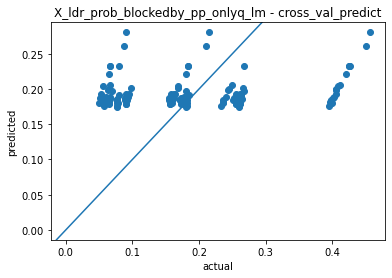

In [23]:
ldr_prob_blockedby_pp_onlyq_lm_results['fitplot']

In [ ]:
ldr_occ_mean_basicq_lm_results = results['ldr_occ_mean_basicq_lm_results']

In [ ]:
ldr_occ_mean_basicq_lm_results.keys()

In [ ]:
plt.plot(ldr_occ_mean_basicq_lm_results['residuals'])

In [ ]:
data_path = "data"
experiment = "exp11"

In [ ]:
X_pp_basicq = pd.read_csv(Path(data_path, f'X_pp_basicq_{experiment}.csv'), index_col=0)

In [ ]:
X_pp_basicq.info()

Several models perform really poorly on the infinite capacity scenarios. Not surprising since they correspond to rho values much lower than for the vast majority of the scenarios.

Seems like we should run an experiment with a more uniform range of rho values.

In [ ]:
plt.scatter(X_pp_basicq.index, X_pp_basicq['rho_pp'])

In [ ]:
siminout_qng_path = Path("data", "raw", "scenario_siminout_qng_exp11.csv")
xy_df = pd.read_csv(siminout_qng_path, index_col=0)

In [ ]:
X_pp_noq_cols = ['arrival_rate', 'mean_los_pp',
                     'c_sect_prob', 'cap_pp']

In [ ]:
xy_df.loc[:, X_pp_noq_cols]

In [ ]:
int('2')

## Debugging obs poly model fits
They are way off. What's wrong.

In [ ]:


figures_path = Path("output", "figures", "exp11", "exp11_obs_obs_occ_mean_q_poly_cv_scatter.png")
Image(filename=figures_path) 

In [ ]:
figures_path = Path("output", "figures", "exp11", "exp11_obs_obs_occ_p95_q_poly_cv_scatter.png")
Image(filename=figures_path) 

In [ ]:
figures_path = Path("output", "figures", "exp11", "exp11_obs_obs_occ_mean_basicq_poly_cv_scatter.png")
Image(filename=figures_path) 

In [ ]:
figures_path = Path("output", "figures", "exp11", "exp11_obs_obs_occ_p95_basicq_poly_cv_scatter.png")
Image(filename=figures_path) 

In [ ]:
experiment = "exp11"
data_path = Path("data")
output_path = Path("output")

raw_data_path = Path("data", "raw")
pickle_filename = f"obs_results1_{experiment}.pkl"

# X matrices
X_obs_noq = pd.read_csv(Path(data_path, f'X_obs_noq_{experiment}.csv'), index_col=0)
X_obs_basicq = pd.read_csv(Path(data_path, f'X_obs_basicq_{experiment}.csv'), index_col=0)
X_obs_q = pd.read_csv(Path(data_path, f'X_obs_q_{experiment}.csv'), index_col=0)

# y vectors
y_obs_occ_mean = pd.read_csv(Path(data_path, f'y_obs_occ_mean_{experiment}.csv'), index_col=0, squeeze=True)
y_obs_occ_p95 = pd.read_csv(Path(data_path, f'y_obs_occ_p95_{experiment}.csv'), index_col=0, squeeze=True)
y_mean_pct_blocked_by_ldr = pd.read_csv(Path(data_path, f'y_mean_pct_blocked_by_ldr_{experiment}.csv'), index_col=0, squeeze=True)
y_condmeantime_blockedbyldr = pd.read_csv(Path(data_path, f'y_condmeantime_blockedbyldr_{experiment}.csv'), index_col=0, squeeze=True)


In [ ]:
obs_occ_mean_basicq_poly_results = \
    crossval_summarize_mm('obs_occ_mean_basicq_poly', 'obs', 'occ_mean',
                          X_obs_basicq, y_obs_occ_mean, scale=False, flavor='poly')

In [ ]:
plt.plot(obs_occ_mean_basicq_poly_results['residuals'])

In [ ]:
obs_occ_mean_q_poly_results = \
    crossval_summarize_mm('obs_occ_mean_q_poly', 'obs', 'occ_mean',
                          X_obs_q, y_obs_occ_mean, scale=False, flavor='poly')

In [ ]:
plt.plot(obs_occ_mean_basicq_poly_results['predictions'])

In [ ]:
obs_occ_mean_basicq_poly_results.keys()

In [ ]:
obs_occ_mean_basicq_poly_results['coeffs_df']

In [ ]:
plt.plot(obs_occ_mean_q_poly_results['predictions'])